Load the required packages

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the classification and regression dataset

In [19]:
cls_data = pd.read_csv("../Week_4/dataset_classification.csv")
reg_data = pd.read_csv("../Week_4/dataset_regression.csv")


In [20]:
X = cls_data.drop(columns=["label"]).to_numpy(dtype=float)
y = cls_data["label"].to_numpy()

Split classification dataset into training data and testing data

In [21]:
seed = 123
rng = np.random.default_rng(seed)
m = X.shape[0]
perm = rng.permutation(m)
train_size = int(0.8 * m)
idx_train, idx_test = perm[:train_size], perm[train_size:]
Xtrain, Ytrain = X[idx_train], y[idx_train]
Xtest, Ytest = X[idx_test], y[idx_test]


Guassian Discrimiant Analysis

In [22]:
def fit_gda(X, y):

    m, n = X.shape
    phi = y.mean() # P(y = 1)
    X0 = X[y == 0]
    X1 = X[y == 1]
    mu0 = X0.mean(axis=0)
    mu1 = X1.mean(axis=0)

    # Shared covariance
    Sigma = np.zeros((n, n), dtype=float)
    for i in range(m):
        mu = mu1 if y[i] == 1 else mu0
        diff = (X[i] - mu).reshape(-1, 1)
        Sigma += diff @ diff.T
    Sigma /= m

    return phi, mu0, mu1, Sigma

def gda_params_to_linear(phi, mu0, mu1, Sigma):

    """Convert GDA parameters to the equivalent logistic form p(y=1|x)=sigma(theta^T x + theta0)."""

    Sigma_inv = np.linalg.pinv(Sigma)
    theta = Sigma_inv @ (mu1 - mu0)
    theta0 = (
        0.5 * (mu0.T @ Sigma_inv @ mu0 - mu1.T @ Sigma_inv @ mu1)
        + np.log(phi / (1 - phi))
    )

    return theta, float(theta0)

def predict_proba(X, theta, theta0):

    z = X @ theta + theta0
    # numerically stable sigmoid
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    expz = np.exp(z[~pos])
    out[~pos] = expz / (1.0 + expz)
    return out

def predict(X, theta, theta0):
    return (predict_proba(X, theta, theta0) >= 0.5).astype(int)

In [23]:
phi, mu0, mu1, Sigma = fit_gda(Xtrain, Ytrain)
theta, theta0 = gda_params_to_linear(phi, mu0, mu1, Sigma)

In [24]:
Yhat_tr = predict(Xtrain, theta, theta0)
Yhat_te = predict(Xtest, theta, theta0)
acc_tr = float(np.mean(Yhat_tr == Ytrain))
acc_te = float(np.mean(Yhat_te == Ytest))

print(f"[Train] accuracy = {acc_tr:.4f} ({Ytrain.sum()} positive / {len(Ytrain)-Ytrain.sum()} negative)")
print(f"[Test ] accuracy = {acc_te:.4f} ({Ytest.sum()} positive / {len(Ytest)-Ytest.sum()} negative)")

[Train] accuracy = 0.5294 (2770 positive / 3662 negative)
[Test ] accuracy = 0.5019 (725 positive / 883 negative)


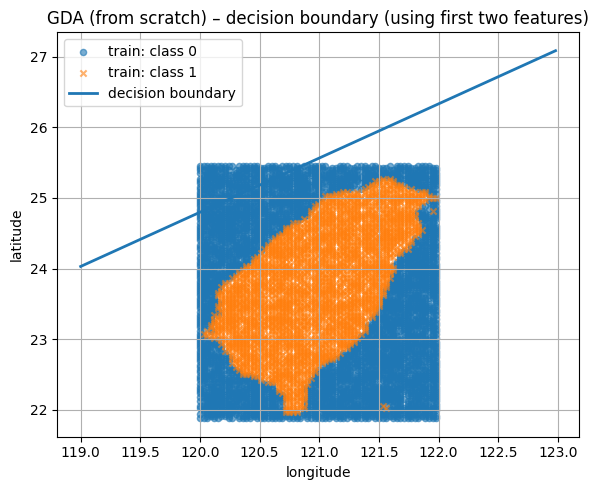

In [25]:
from pathlib import Path
# 5) Plot decision boundary (first two features)
# -----------------------------
nfeat = X.shape[1]
use_cols = (0, 1) if nfeat >= 2 else (0, 0)

Xtr2 = Xtrain[:, list(use_cols)]
Xte2 = Xtest[:, list(use_cols)]

fig = plt.figure(figsize=(6, 5))
ax = plt.gca()

# scatter (train)
ax.scatter(Xtr2[Ytrain==0, 0], Xtr2[Ytrain==0, 1], s=20, alpha=0.6, label="train: class 0")
ax.scatter(Xtr2[Ytrain==1, 0], Xtr2[Ytrain==1, 1], s=20, alpha=0.6, label="train: class 1", marker='x')

# decision boundary only makes sense if at least 2 features.
if nfeat >= 2:
    # We only draw the line implied by the first two coordinates of theta.
    th1, th2 = theta[use_cols[0]], theta[use_cols[1]]
    if abs(th2) < 1e-12:
        # vertical line: theta0 + th1*x1 + th2*x2 = 0 -> x1 = -theta0/th1
        x1 = -theta0 / (th1 + 1e-12)
        xs = np.array([X[:,use_cols[0]].min()-1, X[:,use_cols[0]].max()+1])
        ys = np.full_like(xs, X[:,use_cols[1]].mean())
    else:
        xs = np.linspace(X[:,use_cols[0]].min()-1, X[:,use_cols[0]].max()+1, 200)
        ys = -(theta0 + th1*xs)/th2
    ax.plot(xs, ys, linewidth=2, label="decision boundary")

ax.set_xlabel(cls_data.drop(columns=["label"]).columns[use_cols[0]])
if nfeat >= 2:
    ax.set_ylabel(cls_data.drop(columns=["label"]).columns[use_cols[1]])
ax.set_title("GDA (from scratch) – decision boundary (using first two features)")
ax.legend(loc="best")
ax.grid(True)

out_path = Path("gda_decision_boundary.png")
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()

In [26]:
def fit_qda(X, y, lam=0.1):
    X0, X1 = X[y==0], X[y==1]
    mu0, mu1 = X0.mean(axis=0), X1.mean(axis=0)
    S0 = np.cov(X0, rowvar=False, bias=True) + lam*np.eye(X.shape[1])
    S1 = np.cov(X1, rowvar=False, bias=True) + lam*np.eye(X.shape[1])
    phi = y.mean()
    
    return phi, mu0, mu1, S0, S1

def qda_logp(x, mu, S):
    d = x - mu
    Sinv = np.linalg.pinv(S)
    sign, logdt = np.linalg.slogdet(S)

    return -0.5 * (d @ Sinv @ d) - 0.5 * logdt

def predict_qda(X, phi, mu0, mu1, S0, S1):
    out = np.zeros(X.shape[0], dtype=int)
    for i, x in enumerate(X):
        l0 = np.log(1 - phi) + qda_logp(x, mu0, S0)
        l1 = np.log(phi) + qda_logp(x, mu1, S1)
        out[i] = 1 if l1 > l0 else 0

    return out

In [27]:
# QDA
phi, mu0, mu1, S0, S1 = fit_qda(Xtrain, Ytrain, lam=0.1)
Yhat_tr = predict_qda(Xtrain, phi, mu0, mu1, S0, S1)
Yhat_te = predict_qda(Xtest, phi, mu0, mu1, S0, S1)

In [28]:
acc_tr = float(np.mean(Yhat_tr == Ytrain))
acc_te = float(np.mean(Yhat_te == Ytest))

print(f"[Train] accuracy = {acc_tr:.4f} ({Ytrain.sum()} positive / {len(Ytrain)-Ytrain.sum()} negative)")
print(f"[Test ] accuracy = {acc_te:.4f} ({Ytest.sum()} positive / {len(Ytest)-Ytest.sum()} negative)")

[Train] accuracy = 0.8618 (2770 positive / 3662 negative)
[Test ] accuracy = 0.8464 (725 positive / 883 negative)


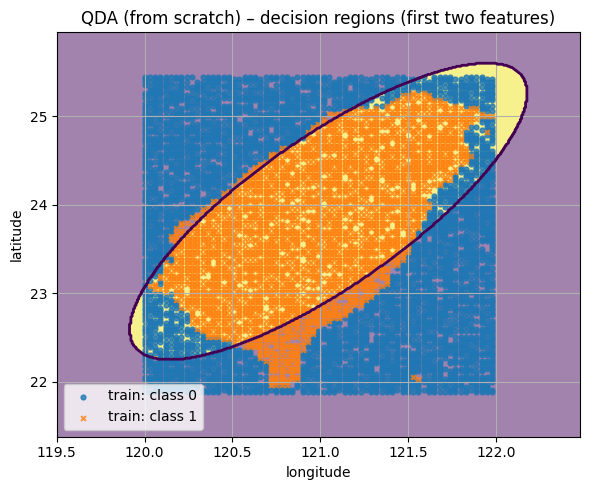

Figure saved to qda_decision_boundary.png


In [29]:
feat_names = cls_data.drop(columns=["label"]).columns.tolist()
i1, i2 = (0, 1) if X.shape[1] >= 2 else (0, 0)

x1_min, x1_max = X[:, i1].min()-0.5, X[:, i1].max()+0.5
x2_min, x2_max = X[:, i2].min()-0.5, X[:, i2].max()+0.5

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 400),
    np.linspace(x2_min, x2_max, 400)
)

Xmean = Xtrain.mean(axis=0)
grid = np.tile(Xmean, (xx1.size, 1))
grid[:, i1] = xx1.ravel()
grid[:, i2] = xx2.ravel()

P1 = predict_qda(grid, phi, mu0, mu1, S0, S1).reshape(xx1.shape)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()
cs = ax.contourf(xx1, xx2, P1, levels=25, alpha=0.5)
ax.contour(xx1, xx2, P1, levels=[0.5], linewidths=2)
ax.scatter(Xtrain[Ytrain==0, i1], Xtrain[Ytrain==0, i2], s=12, alpha=0.8, label="train: class 0")
ax.scatter(Xtrain[Ytrain==1, i1], Xtrain[Ytrain==1, i2], s=12, alpha=0.8, label="train: class 1", marker='x')
ax.set_xlabel(feat_names[i1])
if X.shape[1] >= 2:
    ax.set_ylabel(feat_names[i2])
ax.set_title("QDA (from scratch) – decision regions (first two features)")
ax.legend(loc="best")
ax.grid(True)
out_path = Path("qda_decision_boundary.png")
plt.tight_layout()
plt.savefig(out_path, dpi=140)
plt.show()
print(f"Figure saved to {out_path}")

## (b) How GDA works for classification — LDA vs QDA

### 1) GDA 的基本觀點（生成式）
高斯判別分析（Gaussian Discriminant Analysis, GDA）是假設**類別條件分布**為高斯：
$$
x \mid y=k \sim \mathcal{N}(\mu_k,\,\Sigma_k),\quad k\in\{0,1\},
$$
並以先驗
$$
\phi = \Pr(y=1),\quad \Pr(y=0)=1-\phi .
$$
由貝氏法則得到後驗：
$$
\Pr(y=1\mid x)\;=\;\frac{\phi\,\mathcal{N}(x\mid \mu_1,\Sigma_1)}{(1-\phi)\,\mathcal{N}(x\mid \mu_0,\Sigma_0)+\phi\,\mathcal{N}(x\mid \mu_1,\Sigma_1)} .
$$
決策規則採最大後驗（MAP）：預測 $y=1$ 若 $\Pr(y=1\mid x)\ge 0.5$。

**參數估計**用極大概似（MLE）：
- $\hat{\phi}=\frac{1}{m}\sum_i \mathbb{1}\{y_i=1\}$
- $\hat{\mu}_k=\frac{1}{m_k}\sum_{i:y_i=k}x_i$
- 協方差見下方 LDA/QDA 兩種設定（共用或各自）。

---

### 2) LDA（Linear Discriminant Analysis）
**假設**兩類**共用同一個協方差矩陣**：$\Sigma_0=\Sigma_1=\Sigma$。  
此時兩類對數機率差為**線性**於 $x$：
$$
g(x)\;=\;\log\frac{\Pr(y=1\mid x)}{\Pr(y=0\mid x)}
=\underbrace{(\Sigma^{-1}(\mu_1-\mu_0))}_{\theta}^\top x
+\underbrace{\tfrac12(\mu_0^\top\Sigma^{-1}\mu_0-\mu_1^\top\Sigma^{-1}\mu_1)+\log\frac{\phi}{1-\phi}}_{\theta_0} .
$$
因此決策邊界 $g(x)=0$ 是**一條直線（或高維的超平面）**。

**MLE 的共用協方差**：
$$
\hat{\Sigma}=\frac{1}{m}\sum_{i=1}^m (x_i-\hat{\mu}_{y_i})(x_i-\hat{\mu}_{y_i})^\top .
$$

**優點與何時可用**
- 決策面線性，參數少，**方差小**、穩定度高。
- 當兩類真的只在**均值不同而協方差相近**時，效果好、計算省。
- 適合樣本不多、維度不高、類別形狀近似橢圓且**對齊相同方向**的情境。

**本資料集的解讀（經緯度二維、類別=島內/島外）**
- 以經緯度看，**島內點大致呈一個傾斜橢圓塊**；島外點則在四周。
- 單一直線很難把「島內」從四周的「島外」一次切開，  
  因而 LDA 的測試表現僅約 **~0.52（接近亂猜）**。
- 若一定要用 LDA，加入**收縮/正則化**在 $\Sigma$（$\Sigma+\lambda I$）可改善數值穩定並小幅提升。

---

### 3) QDA（Quadratic Discriminant Analysis）
**假設**兩類**各自**有協方差：$\Sigma_0 \neq \Sigma_1$。  
這時對數機率差成為**二次式**：
$$
g(x)= -\tfrac12(x-\mu_1)^\top\Sigma_1^{-1}(x-\mu_1)
+\tfrac12(x-\mu_0)^\top\Sigma_0^{-1}(x-\mu_0)
-\tfrac12\log\frac{|\Sigma_1|}{|\Sigma_0|} + \log\frac{\phi}{1-\phi},
$$
決策邊界 $g(x)=0$ 是**二次曲線（橢圓/雙曲線等）**。

**MLE 的類別協方差**（偏差型定義，與樣本量規模相容）：
$$
\hat{\Sigma}_k=\frac{1}{m_k}\sum_{i:y_i=k}(x_i-\hat{\mu}_k)(x_i-\hat{\mu}_k)^\top .
$$
實作時常用**數值穩定**技巧：`slogdet` 計算 $\log|\Sigma_k|$、`pinv` 代替直接求逆，並在 $\Sigma_k$ 上做 **ridge 收縮**：$\Sigma_k \leftarrow \Sigma_k+\lambda I$。

**優點與何時可用**
- 能表達**彎曲**邊界，對「各類形狀/伸展方向不同」更貼合（**低偏差**）。
- 當樣本足夠、兩類協方差確實不同時，**明顯優於 LDA**。
- 缺點是參數多，若樣本少或維度高，容易過擬合；需正則化。

**本資料集的解讀**
- 「島內」像一個傾斜的橢圓團塊；「島外」分布廣且方向性不同。  
  這正是**各類協方差不相同**的典型情境 → QDA 邊界會自動形成**包覆島形的彎曲界線**。
- 在同一分割上，QDA 測試正確率約 **~0.86**，遠高於 LDA，符合資料幾何直觀。

---
**小結**：  
GDA 是生成式模型，透過「類別條件高斯」將分類轉為密度估計 + Bayes 決策。  
在本題資料的幾何形狀下，**QDA**能用**不同協方差**產生**彎曲邊界**，自然比**線性的 LDA**有效得多。


In [30]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
# 讀檔
clf_data = pd.read_csv("../Week_4/dataset_classification.csv")
reg_data = pd.read_csv("../Week_4/dataset_regression.csv")

# 標籤/目標欄位名稱（啟發式）
clf_label = next((c for c in clf_data.columns if c.lower() in ("y","label","target","class")), clf_data.columns[-1])
reg_target = next((c for c in reg_data.columns if c.lower() in ("y","label","target","value")), reg_data.columns[-1])

# Xc, yc (for classifier); Xr, yr (for regressor)
Xc = clf_data.drop(columns=[clf_label]).to_numpy(float)
yc_raw = clf_data[clf_label].to_numpy()
uniq = np.unique(yc_raw)
yc = np.vectorize({uniq[0]:0, uniq[1]:1}.get)(yc_raw).astype(int)

Xr_df = reg_data.drop(columns=[reg_target])
yr = reg_data[reg_target].to_numpy(float)

# 找 regression 與 classification 的**共同特徵**做 C(x)
clf_feats = clf_data.drop(columns=[clf_label]).columns.tolist()
reg_feats = Xr_df.columns.tolist()
shared = [c for c in reg_feats if c in clf_feats]
len(shared), shared[:5]


(2, ['longitude', 'latitude'])

QDA classification

In [32]:
phi, mu0, mu1, S0, S1 = fit_qda(Xc, yc, lam=0.1)

MLP regression model

In [51]:
# 4.1 取 Xr、yr
Xr = Xr_df.to_numpy(float)

# 4.2 資料標準化（在訓練集上 fit）
from sklearn.model_selection import train_test_split
Xtr, Xval, ytr, yval = train_test_split(Xr, yr, test_size=0.2, random_state=seed)

X_mean, X_std = Xtr.mean(axis=0), Xtr.std(axis=0) + 1e-12
y_mean, y_std = ytr.mean(), ytr.std() + 1e-12

def zscore_X(X): return (X - X_mean) / X_std
def zscore_y(y): return (y - y_mean) / y_std
def inv_zscore_y(yhat): return yhat * y_std + y_mean

Xtr_z = zscore_X(Xtr); Xval_z = zscore_X(Xval)
ytr_z = zscore_y(ytr); yval_z = zscore_y(yval)

# 4.3 TensorDataset / DataLoader
batch_size = 256
train_ds = TensorDataset(torch.from_numpy(Xtr_z).float(), torch.from_numpy(ytr_z).float().unsqueeze(1))
val_ds   = TensorDataset(torch.from_numpy(Xval_z).float(), torch.from_numpy(yval_z).float().unsqueeze(1))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

# 4.4 簡單 MLP
class MLPRegressor(nn.Module):
    def __init__(self, d_in, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

model = MLPRegressor(d_in=Xr.shape[1], hidden=128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()

# 4.5 訓練 + Early Stopping
best_val = float("inf")
best_state = None
patience, bad = 20, 0
max_epochs = 200

for epoch in range(1, max_epochs+1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()

    # 驗證
    model.eval()
    with torch.no_grad():
        vals = []
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            vals.append(crit(model(xb), yb).item())
        val_loss = float(np.mean(vals))

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
    if bad >= patience:
        break

# 還原最佳權重
if best_state is not None:
    model.load_state_dict(best_state)

print("Best val MSE (z-space):", best_val)


Best val MSE (z-space): 0.20981402695178986


Classification Dataset Prediction

- C_hat is the predicted label by QDA
- R_hat is the hole dataset predicted values by the MLP regression model
- h_hat is the predicted ``label == 1`` data points whose temperature is R_hat, the ``label == 0`` data points temperature would be -999

In [ ]:
C_hat = predict_qda(Xc, phi, mu0, mu1, S0, S1)  # 0/1
with torch.no_grad():
    R_hat = inv_zscore_y(model(torch.from_numpy(zscore_X(Xc)).float().to(device)).cpu().numpy().reshape(-1))
h_hat = np.where(C_hat==1, R_hat, -999.0)

print("Counts -> C=1:", int((C_hat==1).sum()), "C=0:", int((C_hat==0).sum()))
print("Ground True -> C=1:", int((cls_data["label"] == 1).sum()), "C=0:", int((cls_data["label"] == 0).sum()))


Counts -> C=1: 3821 C=0: 4219
Ground True -> C=1: 3495 C=0: 4545


Confusion Matrix on Classfication Dataset

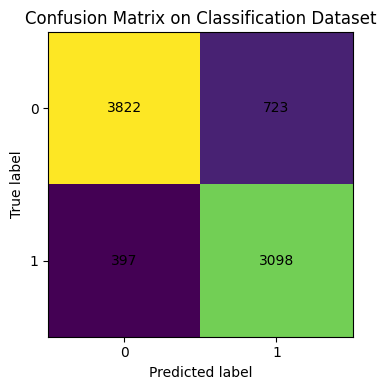

In [82]:
cm = np.zeros((2,2), dtype=int)
for yt, yp in zip(yc, C_hat):
    cm[yt, yp] += 1

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, origin="upper")
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i,j]), ha='center', va='center')
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_title("Confusion Matrix on Classification Dataset")
plt.tight_layout()
cm_path = Path("confusion_matrix.png")
plt.savefig(cm_path, dpi=140); plt.show()

Regression Dataset Prediction

In [91]:
# 全資料（回歸集）做推論
model.eval()
with torch.no_grad():
    Xr_z = zscore_X(Xr)
    y_pred_z = model(torch.from_numpy(Xr_z).float().to(device)).cpu().numpy().reshape(-1)
    R_hat = inv_zscore_y(y_pred_z)   # 反標準化得到原尺度
# 回歸基準 MSE（僅供參考）
mse_reg = float(np.mean((R_hat - yr)**2))
print(f"regression data mse: {mse_reg:.3f}")

C_hat = predict_qda(Xr, phi, mu0, mu1, S0, S1)
h_hat = np.where(C_hat==1, R_hat, -999.0)

regression data mse: 7.775


The first picture is the predicted value vs. groud true plot on regression dataset.

The second picture is the classification result on regression dataset. Since the label of the data points in the regression data is ``1``, there are 397 data points results are wrong. 

Saved: h_piecewise_nn_examples.csv


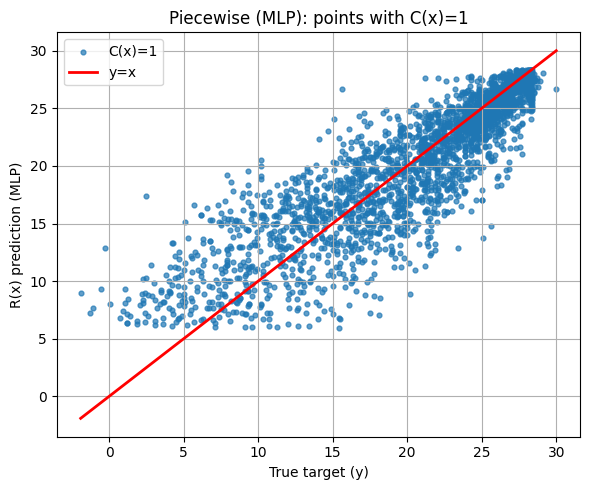

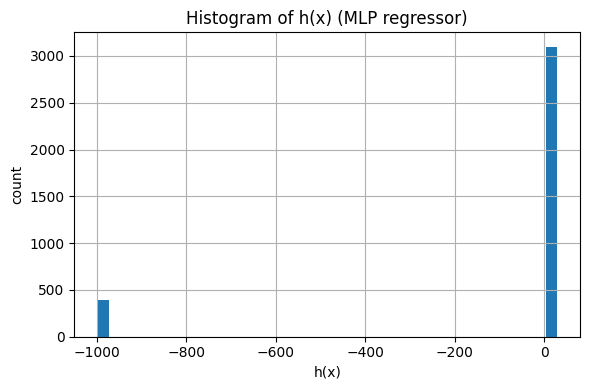

In [93]:
out_df = reg_data.copy()
out_df["C_hat"] = C_hat
out_df["R_hat"] = R_hat
out_df["h_hat"] = h_hat

p_csv = Path("h_piecewise_nn_examples.csv")
out_df.to_csv(p_csv, index=False)
print("Saved:", p_csv)

# (a) 僅在 C=1 的點，R(x) vs y
mask1 = (C_hat==1)
plt.figure(figsize=(6,5))
plt.scatter(yr[mask1], R_hat[mask1], s=12, alpha=0.7, label="C(x)=1")
mn, mx = float(min(yr.min(), R_hat.min())), float(max(yr.max(), R_hat.max()))
plt.plot([mn, mx], [mn, mx], linewidth=2, label="y=x", color="red")
plt.xlabel("True target (y)"); plt.ylabel("R(x) prediction (MLP)")
plt.title("Piecewise (MLP): points with C(x)=1")
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# (b) h(x) 直方圖（應看到 -999 的尖峰）
plt.figure(figsize=(6, 4))
plt.hist(h_hat, bins=40)
plt.title("Histogram of h(x) (MLP regressor)")
plt.xlabel("h(x)"); plt.ylabel("count"); plt.grid(True)
plt.tight_layout(); plt.show()
